In [1]:
import sys
sys.path.append('../src') 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.utils import get_overlap_data_all_sessions,  split_test_train_by_subjects, get_overlap_data_all_sessions
from gait.training import build_cnn_stats_small, train_model_with_stats
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions_with_stats, save_classification_report

In [2]:
build_cnn_stats_small(100, 12, 5, np.ones((1, 12)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 12, 64)  3136        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 12, 64)  256        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [3]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

def get_std_values(X, channel):
    return np.std(X[:, :, channel], axis=1)

def get_mean_values(X, channel):
    return np.mean(X[:, :, channel], axis=1)

def get_max_values(X, channel):
    return np.max(X[:, :, channel], axis=1)

def get_median_values(X, channel):
    return np.median(X[:, :, channel], axis=1)


def get_statistic_feature_all_channels(X):
    statistic_features = []
    for channel in range(9,12):
        statistic_features.append(get_std_values(X, channel))
        statistic_features.append(get_mean_values(X, channel))
        statistic_features.append(get_max_values(X, channel))
        statistic_features.append(get_median_values(X, channel))

    return np.vstack(statistic_features).T

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
unique subjects ['0DXZFsYOfgqsYe0Z' '0UXFxu10k0En1vDK' '19AoxD1bgrDckd2p'
 '1ZstYhEKzKKfGnMW' 'AlOXZjo87HHkXeaa' 'EUbKPOSQgjccjtvi'
 'I1TuySg6fbJ0xeXt' 'KNmC3LADpLyH5qJA' 'KPJOUYXzpivbLfsH'
 'LLZjAPTyj7muHsEf' 'LdH95bTaViXIdDBZ' 'MMuX9YIh4NTbLZLM'
 'NKdnm6cN3KKAx7R4' 'PE8D53oX060qLbdX' 'QFxq3HxMCbzs6bCt'
 'WAb2Ztvv2ux95P4Q' 'YbJVcb4vFFjKKlfe' 'bQsRwKxgJiXTzo6P'
 'c9EB3mOQckRCc8Bz' 'cbOZWnI7s1y8oLD4' 'csujYZktn88ftTTv'
 'ddAeJA42PXvwthbW' 'eqUcL0HkHZfDt0Xs' 'ewpnQDEzR8hTqPRY'
 'kPNKVxgIznp3Vskg' 'nan' 'psiuhPJmLIa2wC4u' 'qyP4saGxcV9UfeQI'
 'sUZBISq61Y7I5tqQ' 'wtyNo4LYaWXrkzA7' 'xYdtS1F8tDyjEIgN'
 'zOmNofnVfbR21Y7n']
Statistic feature shape:  (109637, 12)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:

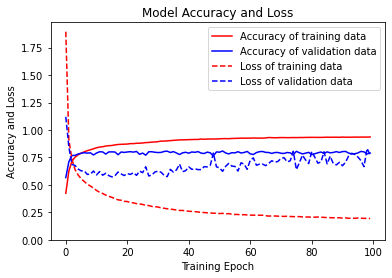

--------CLASSIFICATION REPORT--------
              precision    recall  f1-score   support

           1       0.97      0.96      0.96     10686
           2       0.75      0.79      0.77     10573
           3       0.59      0.72      0.65      5505
           4       0.58      0.72      0.64      2943
           5       0.72      0.52      0.60      8492

    accuracy                           0.76     38199
   macro avg       0.72      0.74      0.73     38199
weighted avg       0.77      0.76      0.76     38199

-------------------------------------


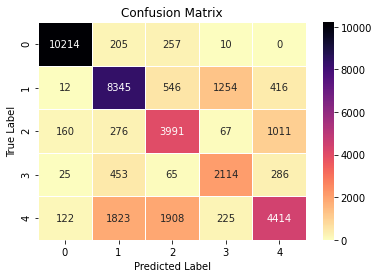

In [4]:
overlapPercents = [90]
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan',
                    'MMuX9YIh4NTbLZLM',
                    'NKdnm6cN3KKAx7R4',
                    'PE8D53oX060qLbdX',
                    'xYdtS1F8tDyjEIgN',
                    'EUbKPOSQgjccjtvi',
                    'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4',
                    '1ZstYhEKzKKfGnMW',
                    'bQsRwKxgJiXTzo6P',
                    'sUZBISq61Y7I5tqQ',
                    '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7',
                    ]

for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        print('unique subjects', np.unique(subjects))
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.8)
        X_train_stats = get_statistic_feature_all_channels(X_train)
        X_test_stats = get_statistic_feature_all_channels(X_test)
        print('Statistic feature shape: ', X_train_stats.shape)

        model, history = train_model_with_stats(
            X_train, y_train, X_test, X_train_stats, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100)

        save_history(history, OVERLAP_PERCENT)
        evaluation_history = model.evaluate(
            [X_test, X_test_stats], y_test, batch_size=128, verbose=1)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions_with_stats(
            model, X_test, y_test, X_test_stats)
        save_classification_report(validations, predictions, OVERLAP_PERCENT)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)
